In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from models.unet import Unet

import matplotlib.pyplot as plt
import numpy as np

## Set up

In [2]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 500
    schedule_type = 'cosine'
    s = 0.008

## Dataset

In [3]:
from torch.utils.data import DataLoader
from data.dataset import CIFAR10_Dataset, MNIST_Dataset

batch_size = CFG.batch_size
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


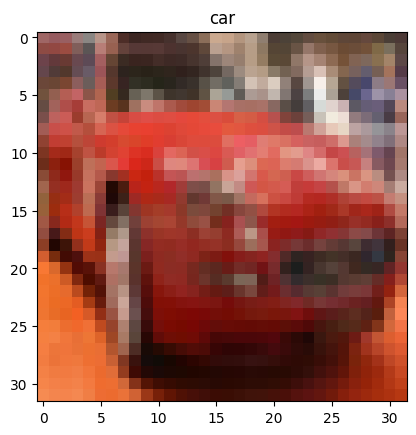

In [4]:
from utils.utils import show_image

image, labels = train[5]
show_image(image, train.classes[labels])

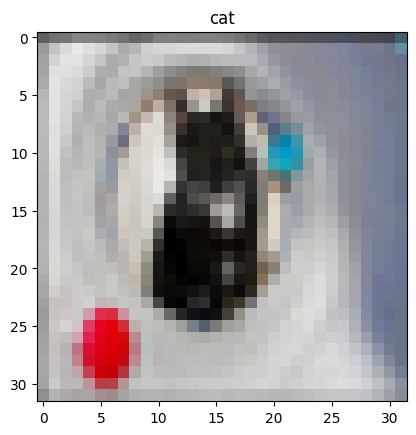

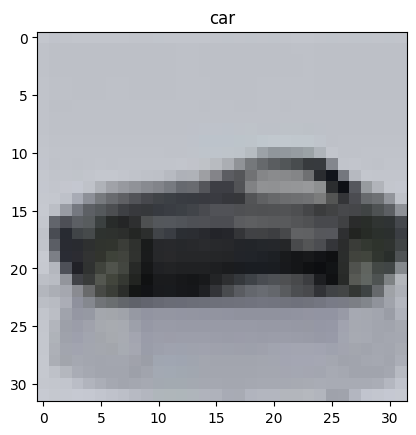

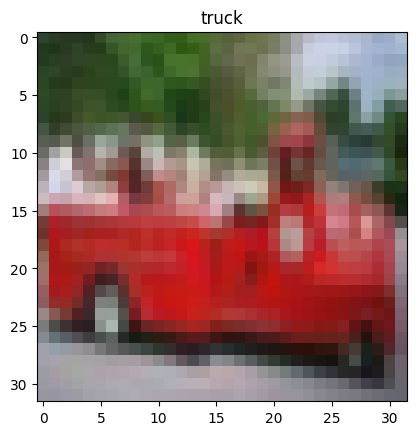

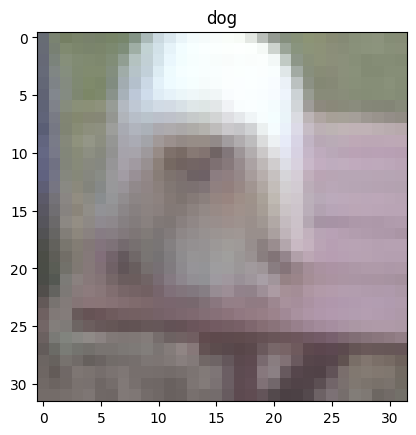

In [5]:
images, labels = next(iter(train_loader))
for image, labels in zip(images, labels):
    show_image(image, train.classes[labels])

## Noise

### Cosine Noise adder

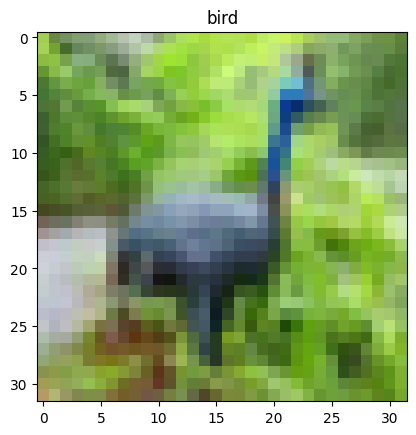

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


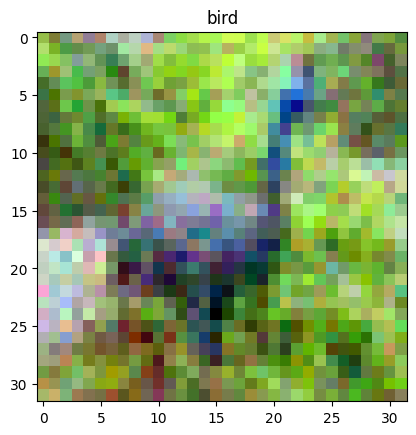

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


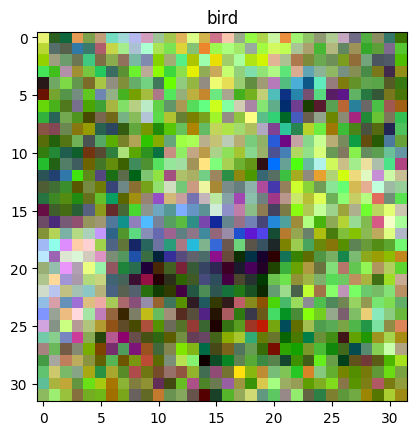

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


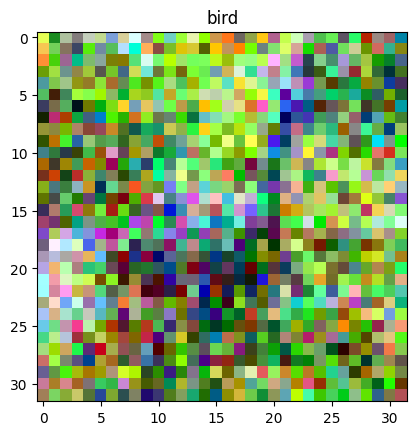

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


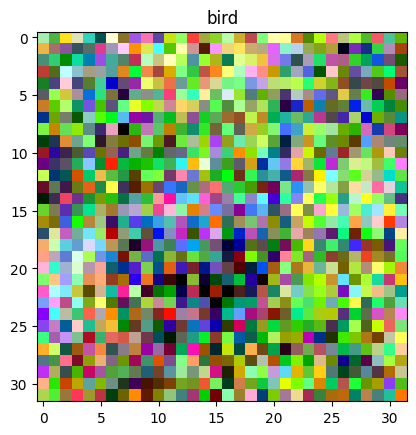

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


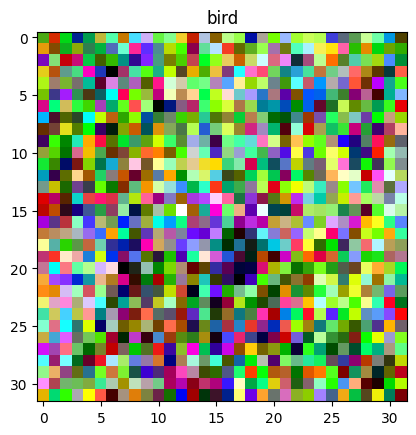

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


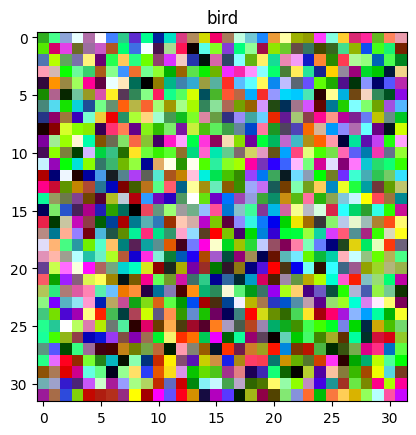

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


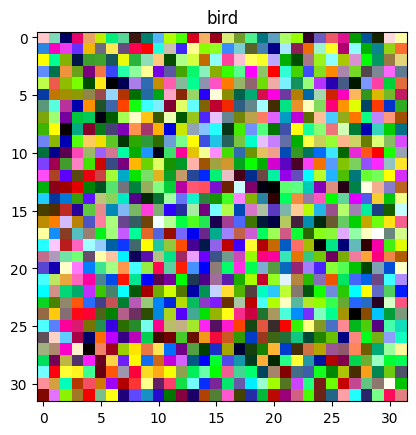

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


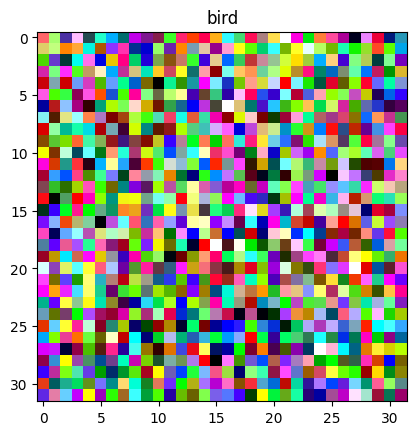

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


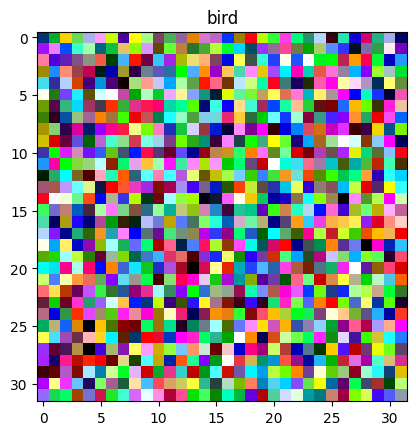

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


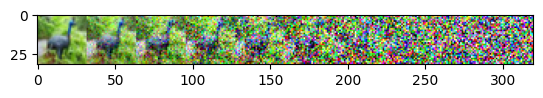

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


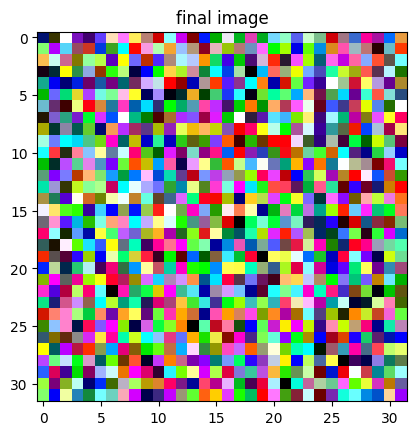

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


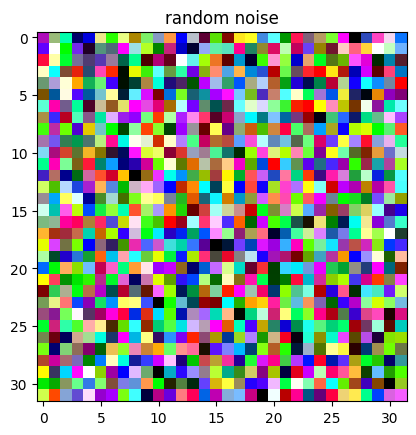

In [6]:
from utils.noise import CosineNoiseAdder

noise_adder = CosineNoiseAdder(CFG.T, CFG.s)

# Example input image
img, labels = train[6]
full_img = torch.tensor([])

# Visualize the noise addition process
for time_steps in torch.arange(0, CFG.T, 50):
    noisy_imgs, noises = noise_adder.image_at_time_step(img, time_steps)
    full_img = torch.cat((full_img, noisy_imgs), 2)
    show_image(noisy_imgs, train.classes[labels])
show_image(full_img)

final_noisy_img, noises = noise_adder.image_at_time_step(img, CFG.T - 1)
show_image(final_noisy_img, title="final image")

final_noise = torch.randn_like(img)
show_image(final_noise, title="random noise")

## Unet Model

In [7]:
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=16)
batch = next(iter(train_loader))
print(batch[0].shape)
# img, label = train[6]
imgs = batch[0]

# fake data for testing
# imgs = torch.randn(16, 3, 128, 128)

Files already downloaded and verified
torch.Size([16, 3, 32, 32])


In [8]:
torch.tensor([34] * 8).shape

torch.Size([8])

In [9]:
net = Unet(16, 3, 8, initial_channels=3)
print("\n", net(imgs, torch.tensor([34])).shape)


 torch.Size([16, 3, 32, 32])


## Noise Dataset

In [10]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        t = torch.randint(self.noise_schedule.T, (1, )).squeeze()
        # print(t)
        # t = 30
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

## Training

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32]) torch.Size([16]) torch.Size([16])
start with shape torch.Size([16, 3, 32, 32])
label shape : torch.Size([16])
label_embeddings shape : torch.Size([16, 8])
label_embeddings shape : torch.Size([16, 8, 1, 1])
label_embeddings shape : torch.Size([16, 8, 32, 32])
after concatenating the timestep embedds : torch.Size([16, 19, 32, 32])
down block 0, with shape torch.Size([16, 19, 32, 32])
down block 1, with shape torch.Size([16, 16, 16, 16])
after bottleneck : shape = torch.Size([16, 32, 16, 16])
up block 0, with shape torch.Size([16, 32, 16, 16]), and skip shape : torch.Size([16, 32, 16, 16])
after final : shape = torch.Size([16, 3, 32, 32])

 torch.Size([16, 3, 32, 32])


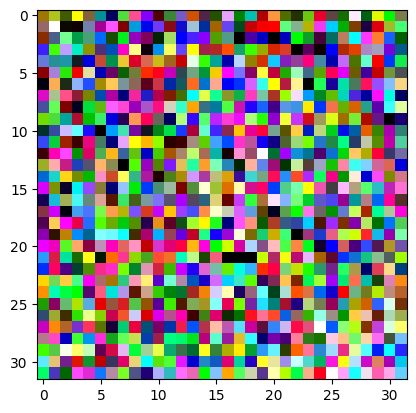

In [11]:
max_time_steps = 1000
batch_size = 16

CosineNoise = CosineNoiseAdder(max_time_steps)

# train = NoiseDataset(MNIST_Dataset(), CosineNoise)
# test = NoiseDataset(MNIST_Dataset('test'), CosineNoise)

train = NoiseDataset(CIFAR10_Dataset(), CosineNoise)
test = NoiseDataset(CIFAR10_Dataset('test'), CosineNoise)

train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

net = Unet(16, depth=2, time_embed_dim=8, label_emb_dim=8, num_label=10, initial_channels=3, conv_layers=1)


noisy_imgs, noises, time_steps, labels = next(iter(train_loader))
print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)

print("\n", net(noisy_imgs, time_steps, labels, verbose=1).shape)
show_image(noisy_imgs[0])

### Weight Initialization

In [37]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight, gain=1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


### Eval

In [109]:
def eval_model(model:nn.Module, _test_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (noisy_imgs, noises, time_steps, labels) in enumerate(_test_loader):
            noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
            outputs = model(noisy_imgs, time_steps, labels)
            loss = criterion(outputs, noises)
            losses.append(loss.item())
            # print(loss, losses)
            # print(f"Batch {i}, Loss: {loss.item()}")
    return sum(losses)/len(losses)

### Training Loop

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
Epoch [1/20], Step [500/3125], Loss: 0.2864, Val Loss: 0.2649, lr: 0.0009998578851774596
Epoch [1/20], Step [1000/3125], Loss: 0.2179, Val Loss: 0.2415, lr: 0.0009994316304726544
Epoch [1/20], Step [1500/3125], Loss: 0.2520, Val Loss: 0.2371, lr: 0.0009987215051171939
Epoch [1/20], Step [2000/3125], Loss: 0.2189, Val Loss: 0.2356, lr: 0.000997727957641475
Epoch [1/20], Step [2500/3125], Loss: 0.2020, Val Loss: 0.2276, lr: 0.0009964516155913771
Epoch [1/20], Step [3000/3125], Loss: 0.2738, Val Loss: 0.2244, lr: 0.0009948932851318955
Epoch [2/20], Step [500/3125], Loss: 0.2732, Val Loss: 0.2309, lr: 0.0009925503422477
Epoch [2/20], Step [1000/3125], Loss: 0.2413, Val Loss: 0.2217, lr: 0.0009903614069462358
Epoch [2/20], Step [1500/3125], Loss: 0.1906, Val Loss: 0.2182, lr: 0.0009878943299417044
Epoch [2/20], Step [2000/3125], Loss: 0.2057, Val Loss: 0.2170,

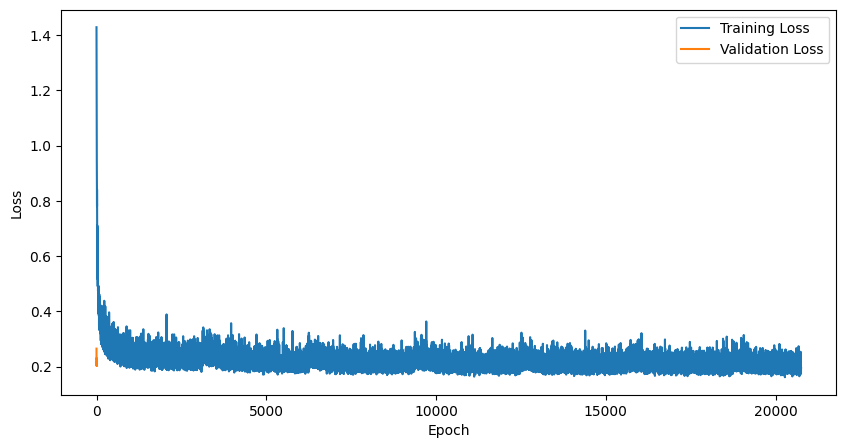

In [113]:
# hyperparameters
n_epochs = 20
batch_size = 16
lr = 1e-3
max_time_steps = 200
eval_every = 500
patience = 5000

# model creation
net = Unet(32, depth=4, time_embed_dim=16, label_emb_dim=16, num_label=10, initial_channels=3, conv_layers=2)
net.apply(init_weights)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1,  gamma=0.316)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs * len(train_loader), eta_min=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=1e-4)

# dataset creation
CIFAR10 = CIFAR10_Dataset()
CosineNoise = CosineNoiseAdder(max_time_steps)
train = NoiseDataset(CIFAR10_Dataset(), CosineNoise)
test = NoiseDataset(CIFAR10_Dataset('test'), CosineNoise)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
net.to(device)

# keep track of the loss
train_losses = []
val_losses = []
best_loss = np.inf
best_loss_i = 0
stoping = False

# training loop
for epoch in range(n_epochs):
    net.train()
    for i, batch in enumerate(train_loader):
        noisy_imgs, noises, time_steps, labels = batch
        noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
        # print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)
        
        optimizer.zero_grad()
        
        predicted_noise = net(noisy_imgs, time_steps, labels)
        loss = criterion(predicted_noise, noises)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if i % eval_every == 0 and i > 0:
            val_loss = eval_model(net, test_loader, criterion, device)
            val_losses.append(val_loss)
            print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_i = epoch * len(train_loader) + i
                torch.save(net.state_dict(), 'best_model_CIFAR.pth')

            if epoch * len(train_loader) + i - best_loss_i > patience:
                print("Stopping early")
                stoping = True
                break
        
        
        # show_image(noisy_imgs[0], title="noisy image")
        # show_image(predicted_noise[0], title="predicted noise")
        
        # break
        scheduler.step()
    # if epoch % 4 == 0:
    #     scheduler.step()
    if stoping:
        break
    # break

plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
plt.plot(np.arange(0, len(val_losses)) * eval_every / len(train_loader), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [114]:
net.load_state_dict(torch.load('best_model_CIFAR.pth'))

<All keys matched successfully>

## Sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


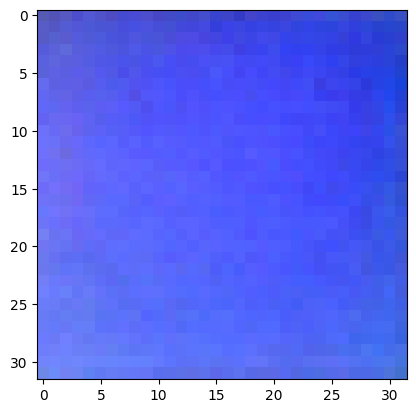

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 320])


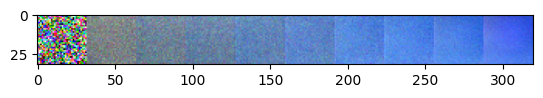

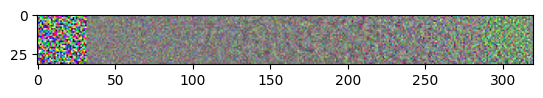

In [118]:
max_time_steps = 100

n_samples = 1
xt = torch.randn((n_samples, 3, 32, 32)).to(device)
T = max_time_steps
s = 0.008

# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
label = torch.tensor([0], device=device)

full_img = torch.tensor([], device=device)
full_predicted_noise = torch.tensor([], device=device)


# print(CosineNoise.get_alpha_t(T))
for _ in range(1):
    with torch.no_grad():
        xt = torch.randn((n_samples, 3, 32, 32)).to(device) 
        for t in torch.arange(max_time_steps, 0, -1):
            t = t.expand((n_samples)).to(device)
            a_t = CosineNoise.get_alpha_t(t)
            alpha_t_barre = CosineNoise.get_alpha_t_barre(t)
            sigma = torch.sqrt(1-a_t).view(n_samples, 1, 1, 1)
            z = torch.randn_like(xt)
            # print(xt.shape)
            epsilon = net(xt, t, label)
            a = ((1 - a_t)/(torch.sqrt(1 - alpha_t_barre))).view(n_samples, 1, 1, 1)
            b = (1/torch.sqrt(a_t)).view(n_samples, 1, 1, 1)
            
            if t.item() % (max_time_steps / 10) == 0:
                full_img = torch.cat((full_img, xt), 3)
                full_predicted_noise = torch.cat((full_predicted_noise, epsilon), 3)
            
            # print(t[0].item(), a_t[0].item(), alpha_t_barre[0].item(), sigma[0].item(), a[0].item(), b[0].item(), z.shape, epsilon.shape, sep=' | ')
            # print(xt.shape, epsilon.shape)
            
            # xt = b*(xt - a*epsilon) + sigma*z

            # xt = torch.sqrt(1 - a_t).view(n_samples, 1, 1, 1) * epsilon + sigma * z
            
            xt = b * (xt - torch.sqrt(1-alpha_t_barre)*epsilon) + sigma*z
            
            # print(xt[0][0][0][0], xt[0][1][0][0], xt[0][2][0][0])
            # print(xt[0])

        show_image(xt[0])
print(full_img.shape)
show_image(full_img[0])
show_image(full_predicted_noise[0])